# Real Estate Pricing Factor Dynamics
{cite}`farevuu2018` continues in Chapter 5 to outline how scenario
outcomes are based on the probability of certain situations or circumstances
occurring. In Chapter 7, the qualities of real estate market dynamics are
described, which are implemented in the *Rangekeeper* "Dynamics" module.

The following characteristics of real estate markets are identified:
1. Non-substitutability and non-fungibility of real estate assets.
2. Inefficiency of information processing in real estate markets.
3. Autoregression in real estate pricing
4. Cyclicality in real estate pricing
5. Mean reversion in real estate pricing

Because of these, the real estate pricing dynamics that are input into
simulations should include autoregression, cyclicality, and mean‐reversion, in
addition to random-walk process.

## Pricing Factors
The methodology to produce a simulation of a real estate market is to use
'pricing factors'; a ratio that multiplies the original, single‐stream pro forma
cash flow expectation to arrive at a future cash flow outcome for a given
scenario.

Pricing factors can capture the historical variations in market prices that are
observed in real estate markets, and can be generated from interpretations of
available market data.

In this methodology, the pricing factors substantially enhance the traditional
random walk process, by recognizing the special features of the dynamics of real
estate markets. The resulting output simulation distributions offer a much
richer and fuller picture of the future than the traditional, single‐stream DCF.

```{figure} resources/FaREVuU-figure7.2.png
---
width: 100%
name: FaREVuU-figure7.2
---
Figure 7.2 from {cite}`farevuu2018`
```

While {cite}`farevuu2018` does not explicitly describe the formulation and
calculations used to produce the Market Dynamics incorporated into later
examples and exercises, their accompanying Excel spreadsheets do provide the
implementation details.

*Rangekeeper* replicates the market dynamics calculations (specifically, the
'MktDynamicsInputs' tab) by generating a `Market` object via five key modules:

1. Market Trend
2. Volatility (including Autoregression and Mean Reversion)
3. Cyclicality
4. Noise
5. Black Swan

`Market`s can be generated in two ways:
 1. Deterministically (mostly); where all inputs are specified and have no
variability (except for those with explicit randomness like volatility or noise)
2. Stochastically; where inputs are sampled from specified distributions of
their likelihoods.

## Producing one Scenario (or 'Trial') `Market`
First, let's introduce a `Market` by specifiying it as deterministically as
possible:

We need some extra libraries this time:

In [1]:
import pandas as pd

import rangekeeper as rk

### Market Span
Like in {cite}`farevuu2018`, we will use a 25-year span. We will also produce
the sequence of periods that will be used in following methods:

In [2]:
frequency = rk.duration.Type.YEAR
num_periods = 25
span = rk.span.Span.from_duration(
    name="Span",
    date=pd.Timestamp(2001, 1, 1),
    duration=frequency,
    amount=num_periods)
sequence = span.to_sequence(frequency=frequency)
span

Span: Span
Start Date: 2001-01-01
End Date: 2025-12-31

### Overall Trend
Now, we set up the general (rental) market trend (excluding volatility), which
requires the following parameters:
1. **Cap Rate:**
   This is the long-run mean cap rate around which the capital market cycle
   varies, that is, this is the cap rate toward which the market reverts over
   the cycle. This relates to the reversion (going-out) cap rate that will be
   applied upon resale.

   ```{note}
   :class: dropdown
   You can set this so that the inflexible (10yr) reversion will exactly match a
   pro-forma reversion amount in the Base Case. Just set this as the ratio of
   the pro-forma Yr11 NOI divided by the pro-forma reversion (gross of selling
   expenses).

   Note that if this long-run cap rate is set to a value much above (below) the
   going-in cap rate implied by the initial price, then the result will be to
   tend to favor flexible resale timing later (earlier), so as to mitigate
   (maximize) the unfavorable (favorable) effect of the yield change between the
   buy and the sell.

   A plausible value for this input would equal the discount rate minus the
   pro-forma growth rate, plus 100 to 200 basis-points for capital improvements
   expenditures.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

   ```{important}
   :class: dropdown
   If an initial price factor is not set, it is defaulted to 1.00, and thus the
   intial rent level (net income as a fraction of asset value) is set equal to
   the cap rate (net income yield). This would also mean that subsequent price
   factors will be ratios of the pro-forma cash flow expectations. You can
   perform a sensitivity analysis by varying the initial price factor.
   ```

2. **Growth Rate:**
   This will govern the central tendency of the long-run growth rate trend that
   will apply over the entire scenario.

   ```{note}
   :class: dropdown
   As Pricing Factors are only RELATIVE TO the traditional pro-forma which
   should contain any realistic expected growth, the default value input here
   should normally be zero in principle.
   However, in the Base Case we make this incremental trend slightly negative to
   counteract the effect of some minor inconsistencies. (The pro forma does not
   recognize any Black Swan probability, and has zero selling expenses. The cap
    rate cycle is symmetric in the cap rate, but that gives resulting capital
   value levels an upward bias. These factors may interact with other elements
   of the price dynamics.) Ideally for a more representative sample and better
   "apples-to-apples" comparisons, you want to set this input so that the
   t-statistic of the InflxPV-ProFormaPV (cell K13) is generally near zero (and
   almost always < 1.96 in absolute value). You may need to change the LR Trend
   Mean input as you change other price dynamics input parameter assumptions
   away from the Base Case assumptions.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

In [3]:
cap_rate = .05
growth_rate = -.0005

In [4]:
trend = rk.dynamics.trend.Trend(
    sequence=sequence,
    cap_rate=cap_rate,
    growth_rate=growth_rate)
print('Growth Rate: {:.4%}'.format(trend.growth_rate))
print('Initial Value: {:.4%}'.format(trend.initial_value))

Growth Rate: -0.0500%
Initial Value: 5.0000%


A `Trend` object is in fact a `Flow` with some extra properties, and so we can
plot it like any other `Flow`:

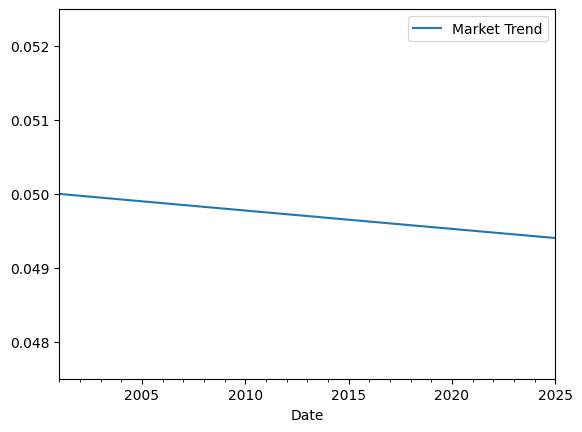

In [5]:
trend.plot(bounds=(0.0475, 0.0525))

### Volatility
Volatility refers to the variation in returns (differences from one period to
the next).
*Rangekeeper* includes autoregression and mean-reversion in its "Volatility"
module.

To introduce volatility, we require the following parameters:

1. **Volatility per Period:**
   This is the standard deviation across time (longitudinal dispersion).
   ```{note}
   :class: dropdown
   Volatility "accumulates" in the sense that the realization of the change in one
   period becomes embedded in the level (of rents) going forward into the next
   period, whose change is then added on top of the previous level (of rents).
   If there is autoregression (inertia in price movements) then that will also
   affect the annual volatility in the rent changes. Cycles will also affect the
   average volatility observed empirically across the scenario.

   Evidence indicates that in mature markets such as the U.S., real estate
   market volatility (not including individual building idiosyncratic risk) is
   on the order of 10%. However, this includes the effect of long-term cycles as
   well as annual accumulating volatility. If you are modeling an individual
   stabilized building, then you should probably set this in the range of 10% to
   15% (which would reflect some idiosyncratic risk as well as market risk).

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

2. **Autoregression Parameter:**
   This reflects the inertia in the price movements.
   ```{note}
   :class: dropdown
   The autoregression parameter indicates what proportion of the previous
   period's return (price change) will automatically become a component of the
   current period's return (price change). The greater this parameter, the more
   inertia or momentum the real estate prices will have.
   In most real estate markets this would typically be a positive fraction,
   perhaps in the range +0.1 to +0.5. In more liquid and informationally
   efficient asset markets such as stock markets you might leave this at zero
   (no inertia). A "noisy" market would have a negative autoregression
   parameter, however, we deal with noise separately.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

3. **Mean-Reversion Parameter:**
   This determines the strength (or speed) of the mean reversion tendency in the
   price levels.
   ```{note}
   :class: dropdown
   This parameter is the proportion of the deviation between the current price
   level and the long-run trend level that will be reduced in each year.
   This should be between zero and 1, probably not very close to 1.
   For example, if the previous price level were 1.0, and the long-term trend
   price level for that period were 1.2, and if the mean reversion parameter
   were 0.5, then 0.5 * (1.2 - 1.0) = 0.10 will be added to this period's price
   level.

   This also imparts inertia or momentum into the real estate prices, but in a
   special way, pulling the prices back towards the long-run trend level (not
   including any cycle that is in the price dynamics).

   Evidence suggests that a mean reversion rate on the order of 0.1 to 0.4 is
   probably appropriate, especially for individual properties (as distinct from
   total market aggregates).

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

In [6]:
volatility_per_period = .1
autoregression_param = .2
mean_reversion_param = .3
volatility = rk.dynamics.volatility.Volatility(
    sequence=sequence,
    trend=trend,
    volatility_per_period=volatility_per_period,
    autoregression_param=autoregression_param,
    mean_reversion_param=mean_reversion_param)

We can now see the volatility with respect to the trend:

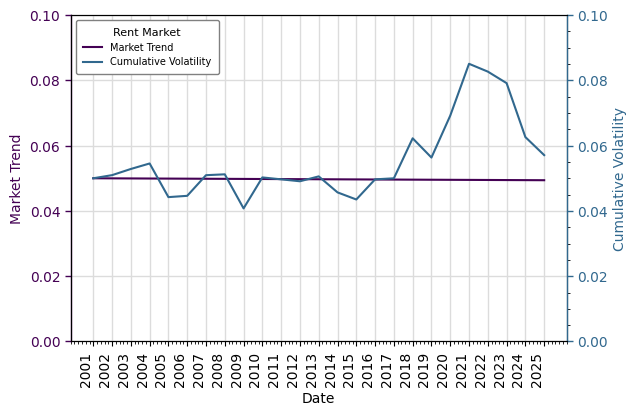

In [8]:
rent_market = rk.flux.Stream(
    name='Rent Market',
    flows=[
        volatility,
        trend
        ],
    frequency=frequency)
rent_market.plot(
    flows={
        'Market Trend': (0., .1),
        'Cumulative Volatility': (0., .1),
        }
    )

### Cyclicality
This models a (possibly somewhat) predictable long-term cycle in the pricing.
In fact, there are two cycles, not necessarily in sync, one for the space market
(rents) and another separate cycle for the asset market (capital flows); the
latter reflected by the cap rate. We model each separately, using generalized
sine functions governed by the given input period, amplitude, and phase.
In addition, there is an *asymmetric* parameter that governs the degree to which
the sine curves are skewed, in order to reflect the sharpness, or quickness,
normally noticed in market downturns as opposed to their upturns.

*Rangekeeper* provides two ways to specify the cyclicality of a `Market`:
1. From sine wave parameters (period, phase, amplitude)
2. From somewhat-observable or estimate-able tendencies in market data, like
   phase offsets, or peak-to-trough height

To reflect how {cite}`farevuu2018` constructs market cycles, we will use the
`from_estimates()` method with the following inputs:

1. **Space (Rent) Cycle Phase Proportion:**
   This governs the proportional positioning of the Space (Rent) Cycle in time,
   relative to a base case (starting mid-cycle, heading up)
   ```{note}
   :class: dropdown
   If you think you know where the market currently is in the cycle, then
   specify the proportion of the cycle period to shift the cycle by (note, since
   this is generated from a sine curve, the base (0) is at mid-cycle, heading
   up. See https://en.wikipedia.org/wiki/Phase_(waves)

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

2. **Space (Rent) Cycle Period:**
   This governs the duration of the Space (Rent) Cycle in time
   ```{note}
   :class: dropdown
   In the U.S. the real estate market cycle seems to be in the range of 10 to 20
   years.
   ```

3. **Space (Rent) Cycle Height:**
    The space cycle height is the peak-to-trough full cycle distance as a
    fraction of the mid-cycle level. (ie, double its amplitude)
   ```{note}
   :class: dropdown
   Historically in the U.S. such cycles in investment property have been as much
   as 50% or more in some markets in the rental market (including both rent
   prices & occupancy effect and considering the leverage that fixed operating
   expenses have on the bottom-line net cash flow). The Pricing Factors in this
   model apply to net cash flows, not just top-line potential gross rental
   revenue.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

4. **Asset (Cap Rate) Cycle Period Difference:**
   This governs the offset/slippage between the Space and Asset Cycles
   ```{note}
   :class: dropdown
   This can be randomly different from rent cycle period, but probably not
   too different, maybe +/- 1 year.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

5. **Asset (Cap Rate) Cycle Phase Difference Proportion:**
   This governs the proportional positioning of the Asset (Cap Rate) Cycle,
   relative (offset) to the Space Cycle
   ```{note}
   :class: dropdown
   The Asset and Space cycles are not generally exactly in sync, but they
   usually are not too far off from each other (e.g.: a quarter-period)

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

6. **Asset (Cap Rate) Cycle Amplitude:**
   This specifies the size of the Asset (Cap Rate) Cycle, in absolute values
   ```{note}
   :class: dropdown
   The Asset (Cap Rate) Cycle operates in addition to (but not entirely
   unrelated to) the Space (Rent) market cycle.
   Cap rates may cycle +/- 100 to 200 basis-points.

   Note that this is in cap rate units, so keep in mind the magnitude of the
   initial cap rate (in the `Market` Trend`).
   For example, if the initial (base) cap rate entered there is 5.00%, and you
   enter 2.00% here, then this will mean a cap rate cycle swinging between
   4.00% & 6.00%, which corresponds roughly to a property value swing of +/-20%
   (other things equal).
   Note also that because this cycle is symmetric but operates in the
   denominator of the pricing factors governing the simulated future cash flows,
   this cycle imparts a positive bias into the project ex post cash flows
   relative to the proforma expected cash flows, whenever there is reversion.

   (From {cite}`farevuu2018`, accompanying Excel spreadsheets)
   ```

7. **Cycle Asymmetric Parameters:**
   The asymmetric parameter governs the degree to which the cycle waveform is
   skewed from its base (sine) form to resemble more of a 'sawtooth'.
   This can be used to generate waveforms that reflect market tendencies where
   downturns are often sharper and quicker than subsequent recoveries.
   ```{note}
   :class: dropdown
   This is a parameter between -1 and 1, where 0 indicates no asymmetry and -1/1
   are extremes where the upturn/downturn is almost immediate. A value of 0.5
   would represent the recovery to last twice as long as the downturn.
   ```

In [9]:
cyclicality = rk.dynamics.cyclicality.Cyclicality.from_estimates(
    space_cycle_phase_prop=0,
    space_cycle_period=13.8,
    space_cycle_height=1,
    space_cycle_asymmetric_parameter=.5,
    asset_cycle_period_diff=0.8,
    asset_cycle_phase_diff_prop=-.05,
    asset_cycle_amplitude=.02,
    asset_cycle_asymmetric_parameter=.5,
    sequence=sequence)

We can now visualize the 'pure' cycles of the space and asset markets:

```{warning}
Note the Asset (Cap Rate) Cycle is modelled as the negative of actual cap rate
cycle. This makes this cycle directly reflect the asset pricing, as prices are
an inverse function of the cap rate. By taking the negative of the actual cap
rate, we therefore make it easier to envision the effect on prices.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

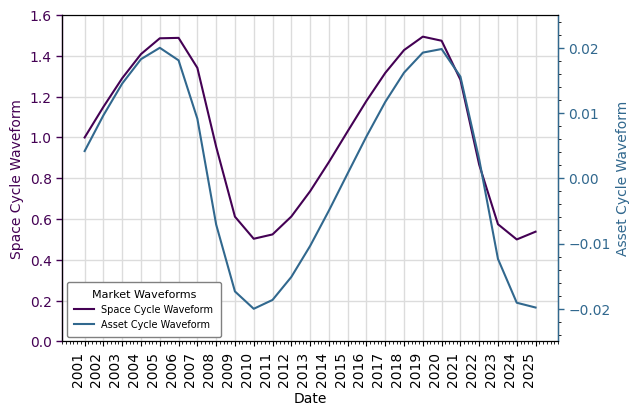

In [11]:
market_waves = rk.flux.Stream(
    name='Market Waveforms',
    flows=[cyclicality.space_waveform, cyclicality.asset_waveform],
    frequency=frequency)
market_waves.plot(
    flows={
        'Space Cycle Waveform': (0, 1.6),
        'Asset Cycle Waveform': (-0.025, 0.025)
        }
    )


### Noise
Noise models the random realization of "deal noise." Similar to volatility, only
unlike volatility noise does not accumulate over time. It applies directly to
the value LEVELs (not returns).

```{note}
By definition, deal-level noise would not exist at the level of aggregate market
prices, so you may want to zero out this parameter here if you're not using this
sheet to represent individual asset or project values.

{cite}`farevuu2018` use a triangular distribution to model noise, though any
sampleable distribution is possible with *Rangekeeper*.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

Noise uses a "half-range" (or 'residual' of a symmetric distribution) around
0.0 as an input.

In [12]:
noise = rk.dynamics.noise.Noise(
    sequence=sequence,
    noise_dist=rk.distribution.Symmetric(
        type=rk.distribution.Type.TRIANGULAR,
        residual=.1))

### Black Swan
A Black Swan is an event that comes as a surprise and has a major effect on the
`Market`, outside of its other modelled factors. To simplify the nature of a
Black Swan event, {cite}`farevuu2018` model it as a potentially-once-in-a-span
immediate downturn that dissipates over time.

{cite}`farevuu2018` constructs Black Swans with the following input parameters:

1. **Black Swan Probability:**
   This is the likelihood of a "Black Swan" event occurring in any one year,
   given that it has not occurred yet in the scenario.

2. **Black Swan Effect:**
   This should probably be a negative fraction, as "black swans" are usually
   negative impacts. Perhaps a fraction in the range of -0.2 to -0.4 could be
   consistent with historical experience.

```{note}
{cite}`farevuu2018` dissipate Black Swan events over time, geometrically, at the
same mean reversion rate as is applied in general to the rents (in the
"Volatility" module)

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

In [13]:
black_swan = rk.dynamics.black_swan.BlackSwan(
    sequence=sequence,
    likelihood=.05,
    dissipation_rate=mean_reversion_param,
    probability=rk.distribution.Uniform(),
    impact=-.25)

### Putting it all Together
A *Rangekeeper* `Market` integrates the previous modules to produce an object
with two important attributes for use in Proforma DCFs:
1. **Space Market Price Factors:**
   This is the "true value" Pricing Factor for just the space market, not
   reflecting the asset market cycle (cap rate).
   We have actually already computed this, and we're here just making it into a
   ratio of the initial rent, in order to calibrate it as a Pricing Factor to be
   applied multiplicatively to the Pro Forma Base Case cash flows. This series
   of Pricing factors will apply to operating cash flows.

2. **Implied Reversion Cap Rates:**
   These are the forward-looking cap rates implied for each year of the
   scenario. These will govern the reversion (resale) cash flows in the DCF
   model of PV.


```{note}
*Rangekeeper* constructs these as a `Flow`s, that can be used in a `Stream` for
multiplication (most presumably, against either Space-based income Cash Flow like
rents, or Asset-based incomes like Reversions (Dispositions))
```

In [14]:
market = rk.dynamics.market.Market(
    sequence=sequence,
    trend=trend,
    volatility=volatility,
    cyclicality=cyclicality,
    noise=noise,
    black_swan=black_swan)

We can replicate (as good as possible) the table in 'MktDynamicsInputs' tab in
the accompanying Excel spreadsheets to {cite}`farevuu2018` like so:

In [16]:
table = rk.flux.Stream(
    name='Market Dynamics',
    flows=[
        market.trend,
        market.volatility.volatility,
        market.volatility.autoregressive_returns,
        market.volatility,
        market.cyclicality.space_waveform,
        market.space_market,
        market.cyclicality.asset_waveform,
        market.asset_market,
        market.asset_true_value,
        market.space_market_price_factors,
        market.noisy_value,
        market.historical_value,
        market.implied_rev_cap_rate,
        market.returns
        ],
    frequency=frequency)
table

date,Market Trend,Volatility,Autoregressive Returns,Cumulative Volatility,Space Cycle Waveform,Space Market,Asset Cycle Waveform,Asset Market,Asset True Value,Space Market Price Factors,Noisy Value,Historical Value,Implied Cap Rate,Returns
2001,0.05,0.06,0.06,0.05,1.00,0.05,0.00,0.05,1.09,1.00,1.14,1.14,0.05,0.20
2002,0.05,0.01,0.02,0.05,1.15,0.06,0.01,0.04,1.45,1.17,1.37,1.37,0.05,0.32
2003,0.05,0.04,0.04,0.05,1.29,0.07,0.01,0.04,1.92,1.36,1.81,1.81,0.04,-0.00
2004,0.05,0.04,0.05,0.05,1.41,0.08,0.02,0.03,2.42,1.54,2.40,1.80,0.04,0.08
2005,0.05,-0.17,-0.16,0.04,1.49,0.07,0.02,0.03,2.19,1.31,2.36,1.94,0.03,-0.02
2006,0.05,0.00,-0.03,0.04,1.49,0.07,0.02,0.03,2.08,1.33,2.16,1.90,0.04,-0.21
2007,0.05,0.11,0.11,0.05,1.34,0.07,0.01,0.04,1.67,1.37,1.64,1.50,0.03,-0.47
2008,0.05,-0.01,0.01,0.05,0.95,0.05,-0.01,0.06,0.86,0.98,0.84,0.79,0.03,-0.55
2009,0.05,-0.20,-0.20,0.04,0.61,0.02,-0.02,0.07,0.37,0.50,0.37,0.36,0.07,-0.10
2010,0.05,0.21,0.17,0.05,0.50,0.03,-0.02,0.07,0.36,0.51,0.33,0.32,0.08,0.17


And plot the key `Flow`s with:

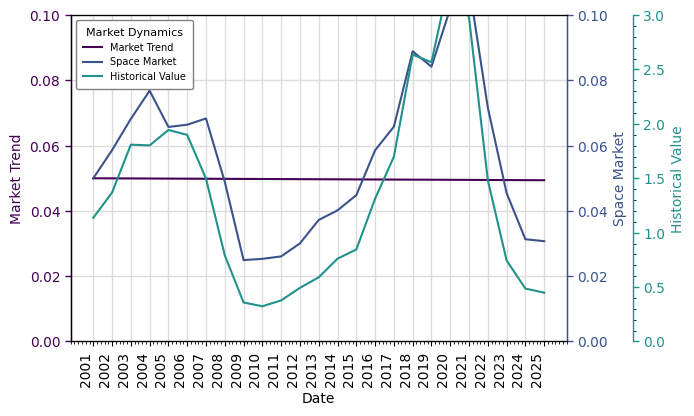

In [17]:
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Space Market': (0, .1),
            'Historical Value': (0, 3)
            }
        )

We can replicate the plot of various sources of risk and dynamics shown
separately:

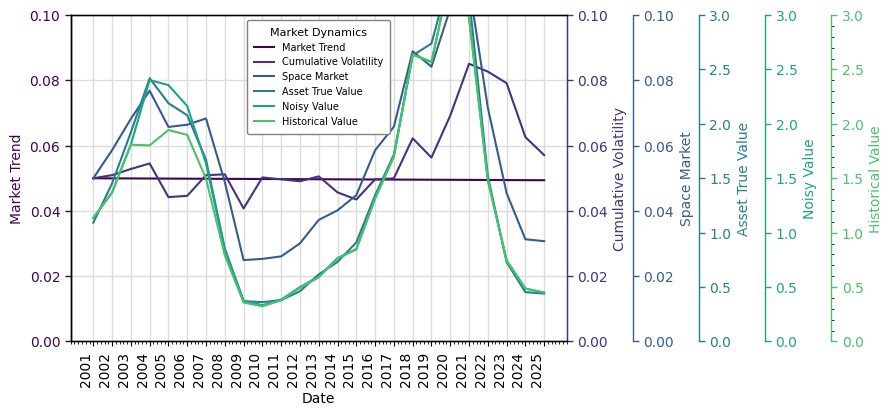

In [18]:
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Cumulative Volatility': (0, .1),
            'Space Market': (0, .1),
            'Asset True Value': (0, 3),
            'Noisy Value': (0, 3),
            'Historical Value': (0, 3)
            }
    )